In [7]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import re
import seaborn as sns
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

## Load Files

In [8]:
# Read all columns and concatenate them into a single dataframe
df = pd.read_csv("scibert_aug_full_df.csv", header = 0, sep="\t", index_col=0)

In [9]:
for i in range (len(df)):
    df['Abstract'].iloc[i] = df['Abstract'].iloc[i][len(df['Document Title'].iloc[i]):]

/tmp/ipykernel_164681/2258888020.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Abstract'].iloc[i] = df['Abstract'].iloc[i][len(df['Document Title'].iloc[i]):]
/tmp/ipykernel_164681/2258888020.py:2: SettingWithCopyWarning: 
A value 

In [10]:
df.columns

Index(['JIF', 'Year Published', 'Abstract', 'Funding', 'Cited Reference Count',
       'Times cited', 'Usage Count (Since 2013)', 'Page Count', 'num_auth',
       'num_words', 'Auth_country', 'Pub_country', 'Document Title',
       'Publication Name', 'Author Keywords', 'Predicted'],
      dtype='object')

In [11]:
df.describe()

,JIF,Year Published,Cited Reference Count,Times cited,Usage Count (Since 2013),Page Count,num_auth,num_words,Predicted
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.00000,1359.000000,1359.000000,1359.000000
mean,4.169660,2010.554820,39.434879,34.935247,9.782929,9.46284,7.866078,224.070640,4.180360
std,2.219096,6.734917,17.865312,50.942460,15.664349,3.56611,4.002910,73.316457,1.729292
min,0.193000,2000.000000,0.000000,0.000000,0.000000,3.00000,1.000000,18.000000,-0.640202
25%,2.572000,2005.000000,28.000000,9.000000,3.000000,7.00000,5.000000,175.000000,3.086818
50%,3.706000,2010.000000,37.000000,20.000000,6.000000,9.00000,7.000000,228.000000,3.976940
75%,5.264000,2016.000000,48.000000,39.000000,12.000000,11.00000,10.000000,264.000000,5.013460
max,15.147000,2022.000000,191.000000,713.000000,271.000000,35.00000,32.000000,559.000000,12.974958


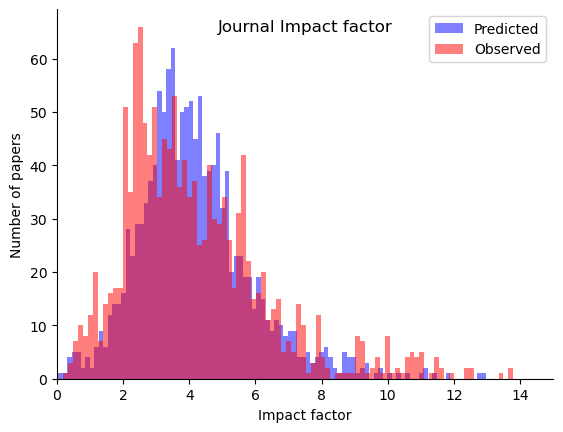

In [12]:
features = ['Year Published', 'JIF', 'Page Count', 'Times cited', 'Predicted']
fig, ax = plt.subplots()

ax.hist(df[features[4]], bins=100, fc=(0, 0, 1, 0.5), label='Predicted')
ax.hist(df[features[1]], bins=100, fc=(1, 0, 0, 0.5), label='Observed')
ax.set_title('Journal Impact factor', y=1.0, pad=-16)
ax.set_xlim(0,15)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Impact factor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc="upper right")
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'JIF_hist.png')
fig.savefig(fig_path, dpi=100)

In [13]:
class JIF_ranker:
    def __init__(self):
        self.LUT = pd.DataFrame()


    def fit(self, series: pd.Series):
        self.LUT = pd.DataFrame(series.groupby(series).size().cumsum()/len(series))
        self.LUT.columns = ['Rank']
        self.LUT.reset_index(inplace = True)
        self.LUT.columns = ['JIF', 'Rank']


    def rank_to_JIF(self, rank:float):
        if (rank <= 1) & (rank >= 0):
            idx = (self.LUT['Rank']- rank).abs().argsort()[:2].sort_values()
            JIF_before = self.LUT.iloc[idx]['JIF'].iloc[0]
            JIF_after = self.LUT.iloc[idx]['JIF'].iloc[1]
            rank_before = self.LUT.iloc[idx]['Rank'].iloc[0]
            rank_after = self.LUT.iloc[idx]['Rank'].iloc[1]
            JIF_to_return = JIF_before + (JIF_after-JIF_before)*(rank-rank_before)/(rank_after-rank_before)
        else:
            JIF_to_return = False
        return JIF_to_return
    
    def JIF_to_rank(self, JIF:float):
        idx = (self.LUT['JIF']- JIF).abs().argsort()[:2].sort_values()
        JIF_before = self.LUT.iloc[idx]['JIF'].iloc[0]
        JIF_after = self.LUT.iloc[idx]['JIF'].iloc[1]
        rank_before = self.LUT.iloc[idx]['Rank'].iloc[0]
        rank_after = self.LUT.iloc[idx]['Rank'].iloc[1]
        rank_to_return = rank_before + (rank_after-rank_before)*(JIF-JIF_before)/(JIF_after-JIF_before)
        return rank_to_return

In [14]:
observed_ranker = JIF_ranker()
observed_ranker.fit(df['JIF'])
df['Observed rank'] = df['JIF'].apply(lambda x: observed_ranker.JIF_to_rank(x))

In [15]:
predicted_ranker = JIF_ranker()
predicted_ranker.fit(df['Predicted'])
df['Predicted rank'] = df['Predicted'].apply(lambda x: predicted_ranker.JIF_to_rank(x))

In [16]:
def rank_to_quart(rank):
    if rank <=0.25:
        return 1
    elif rank <=0.5:
        return 2
    elif rank <=0.75:
        return 3
    elif rank <=1:
        return 4
    else:
        return 'Error'

df['Predicted quartile'] = df['Predicted rank'].apply(rank_to_quart)
df['Observed quartile'] = df['Observed rank'].apply(rank_to_quart)

In [17]:
# See if predicted correlates with times cited beter than JIF
for year in range(2002, 2022):
    cor_JIF = np.corrcoef(df[df['Year Published']==year]['JIF'], df[df['Year Published']==year]['Times cited'])[0][1]
    cor_Pred = np.corrcoef(df[df['Year Published']==year]['Predicted'], df[df['Year Published']==year]['Times cited'])[0][1]
    print(f'Corr for JIF: {round(cor_JIF,3)}, for Predicted: {round(cor_Pred, 3)}, dif: {round(cor_Pred-cor_JIF, 3)}')

cor_JIF =[]
for year in range(2002, 2022):
    cor_JIF.append(np.corrcoef(df[df['Year Published']==year]['JIF'], df[df['Year Published']==year]['Times cited'])[0][1])

print(f'Average correlation between JIF and times cieted: {round(np.mean(cor_JIF),3)}, std_div: {round(np.std(cor_JIF),3)}')

Corr for JIF: 0.273, for Predicted: 0.331, dif: 0.058
Corr for JIF: 0.489, for Predicted: 0.349, dif: -0.14
Corr for JIF: 0.492, for Predicted: 0.474, dif: -0.017
Corr for JIF: 0.348, for Predicted: 0.319, dif: -0.029
Corr for JIF: 0.28, for Predicted: 0.484, dif: 0.204
Corr for JIF: 0.112, for Predicted: 0.051, dif: -0.062
Corr for JIF: 0.541, for Predicted: 0.417, dif: -0.124
Corr for JIF: 0.41, for Predicted: 0.501, dif: 0.091
Corr for JIF: 0.382, for Predicted: 0.625, dif: 0.243
Corr for JIF: 0.157, for Predicted: 0.103, dif: -0.054
Corr for JIF: 0.481, for Predicted: 0.532, dif: 0.051
Corr for JIF: 0.518, for Predicted: 0.594, dif: 0.076
Corr for JIF: 0.452, for Predicted: 0.312, dif: -0.139
Corr for JIF: 0.384, for Predicted: 0.446, dif: 0.062
Corr for JIF: 0.482, for Predicted: 0.2, dif: -0.282
Corr for JIF: 0.51, for Predicted: 0.482, dif: -0.029
Corr for JIF: 0.308, for Predicted: 0.358, dif: 0.051
Corr for JIF: 0.586, for Predicted: 0.656, dif: 0.07
Corr for JIF: 0.469, for P

In [18]:
spike = df[(df['JIF']>2.3) & (df['JIF']<2.6)]
spike.to_csv('spike.csv', sep = '\t')

In [43]:
X_train = df[['Year Published', 'Funding', 'Cited Reference Count', 'Page Count', 'num_auth',
       'num_words',
       'Publication Name']]
X_train = pd.get_dummies(X_train, drop_first=True)
y_train = df['JIF'] - df['Predicted']

In [44]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
coeff_parameter = pd.DataFrame(model.coef_,X_train.columns,columns=['Coefficient'])
coeffs = coeff_parameter.sort_values(by = 'Coefficient', ascending=False)

LinearRegression()

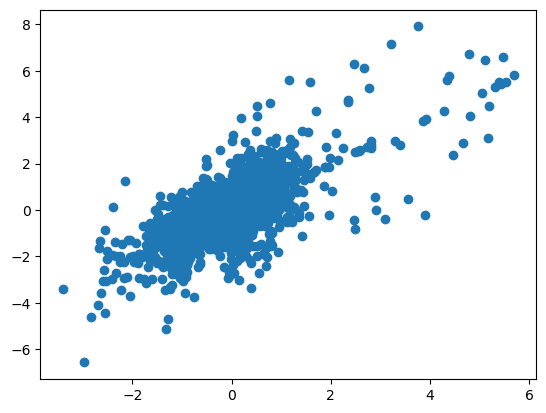

In [47]:
y_pred = model.predict(X_train)
fig, ax = plt.subplots()
ax.scatter(y_pred, y_train)
plt.show()

In [48]:
np.corrcoef(y_pred, y_train)

array([[1.        , 0.72834938],
       [0.72834938, 1.        ]])

In [49]:
coeffs

,Coefficient
Publication Name_jacc-cardiovascular imaging,5.831565
Publication Name_journal of controlled release,5.407532
Publication Name_chinese chemical letters,5.337275
Publication Name_proceedings of the national academy of sciences of the united states of america,5.281515
Publication Name_cancer letters,5.070590
...,...
Publication Name_protein expression and purification,-2.378866
Publication Name_materials,-2.420170
Publication Name_neurochemical journal,-2.682773
Publication Name_bmc cancer,-2.756087


In [58]:
X_train = df[['Publication Name']]
X_train = pd.get_dummies(X_train, drop_first=True)
y_train = df['JIF'] - df['Predicted']

model = LinearRegression()
model.fit(X_train,y_train)
coeff_parameter = pd.DataFrame(model.coef_,X_train.columns,columns=['Coefficient'])
coeffs = coeff_parameter.sort_values(by = 'Coefficient', ascending=False)
y_pred = model.predict(X_train)
np.corrcoef(y_pred, y_train)

array([[1.        , 0.71180198],
       [0.71180198, 1.        ]])

In [60]:
coeffs.head(10)

,Coefficient
Publication Name_jacc-cardiovascular imaging,5.403790
Publication Name_journal of controlled release,5.303496
Publication Name_proceedings of the national academy of sciences of the united states of america,5.203615
Publication Name_chinese chemical letters,5.186336
Publication Name_plant cell,4.912337
Publication Name_circulation,4.441873
Publication Name_cancer letters,4.158402
Publication Name_current biology,3.784562
Publication Name_nature protocols,3.717128
Publication Name_molecular psychiatry,3.386408
